# Assignment 8: Supervised Learning

This should be a straightforward assignment and is here just to provide a concrete example of supervised learning.

Load the titanic data set from `seaborn`. We will try to predict survival from the other variables.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
titanic = sns.load_dataset('titanic')

**Ex 1**. (10 points)

Is the data set balanced or imbalanced? If it is badly imbalanced (say minority class under 20% of total), use down-sampling of the majority class to generate a balanced data set. Drop columns with any missing values.

In [2]:
titanic = titanic.dropna(axis = 1) # drop columns with missing values

In [3]:
titanic = titanic.drop(['alive'], axis = 1) # remove alive column since it will perfectly predict survived

In [4]:
titanic.groupby('survived').size().reset_index(name='counts')

,survived,counts
0,0,549
1,1,342


In [5]:
len(titanic.survived)

891

Total n = 891

In [6]:
titanic.survived[titanic.survived == 1].sum() / len(titanic.survived)

0.3838383838383838

The minority class is greater than 20%, so down-sampling is not necessary.

The data set is not too imbalanced, so no action taken.

**Ex 2**. (10 points)

Convert the categorical values into dummy encoded variables , dropping the first value to avoid collinearity.

We need to convert the categorical values with more than 2 levels. We will need to do this for `pclass`, `sibsp`, `parch`, and possibly `class`.

In [7]:
titanic.head()

,survived,pclass,sex,sibsp,parch,fare,class,who,adult_male,alone
0,0,3,male,1,0,7.2500,Third,man,True,False
1,1,1,female,1,0,71.2833,First,woman,False,False
2,1,3,female,0,0,7.9250,Third,woman,False,True
3,1,1,female,1,0,53.1000,First,woman,False,False
4,0,3,male,0,0,8.0500,Third,man,True,True


In [8]:
titanic_dummies = pd.get_dummies(titanic, columns = ['pclass', 'sex', 'sibsp', 'parch', 
                                                     'class', 'who', 'adult_male', 'alone'], 
                                 drop_first = True)

**Ex 3**. (10 points)

Split the data into 70% training and 30% test data sets using stratified sampling on the sex.

I am assuming you want us to have two training data sets and two testing data sets, where each data set consists of solely males/females.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = titanic_dummies.iloc[:, 1:]
Y = titanic_dummies.iloc[:, 0]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, stratify = X['sex_male'], 
                                                    random_state = 2017)

**Ex 4**. 20 points)

Construct an `sklearn` `Pipeline` with the components `StandardScaler`, `RidgeClassifier`, and `GridSearchCV`. Train the Pipeline classifier, choosing a value for $\lambda$ from one of $\lambda = \{0, 0.1, 1, 10\}$ using grid search with 5-fold cross-validation. Note that the $\lambda$ parameter we use in the lecture is named `alpha` in `RidgeClassifier`.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {'alpha': [0, 0.1, 1, 10]}
pipeline = Pipeline(steps = [("scale", StandardScaler()), 
                             ("gridsearch", GridSearchCV(
                                 RidgeClassifier(random_state = 2017), cv = 5, param_grid = param_grid))])

In [14]:
model_fit = pipeline.fit(X_train, y_train)

In [15]:
model_fit.named_steps['gridsearch'].best_params_

{'alpha': 0}

Our best $\lambda$ parameter = 0

In [16]:
model_predict = model_fit.predict(X_test)

In [17]:
scores = model_fit.decision_function(X_test)

**Ex 5**. (10 points)

Using the trained classifier, construct a confusion matrix for the test and predicted values 

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion = confusion_matrix(y_true = y_test, y_pred = model_predict, labels = [0, 1])
print(confusion)

[[144  26]
 [ 32  66]]


Total Number of predictions

In [20]:
confusion.sum()

268

Correct Predictions:

In [21]:
confusion.trace()

210

Incorrect Predictions:

In [22]:
confusion.sum() - confusion.trace()

58

Accuracy:

In [23]:
confusion.trace() / confusion.sum()

0.7835820895522388

It seems to have correctly predicted 78% of the labels.

**Ex 6**. (10 points)

Using the confusion matrix, calculate accuracy, sensitivity, specificity, PPV, NPV and F1 score 

    TN = True Negative (Row 1, Column 1 in our matrix)
    TP = True Positive (Row 2, Column 2 in our matrix)
    FP = False Positive (Row 1, Column 2 in our matrix)
    FN = False Negative (Row 2, Column 1 in our matrix)

In [24]:
TN = confusion[0, 0]
TP = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]

Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

In [25]:
(TP + TN) / (TP + TN + FP + FN)

0.7835820895522388

    Accuracy = 78%

Sensitivity = $\frac{TP}{TP + FN}$

In [26]:
TP / (TP + FN)

0.673469387755102

    Sensitivity = 67%

Specificity =  $\frac{TN}{TN + FP}$

In [27]:
TN / (TN + FP)

0.8470588235294118

    Specificity = 85%

Positive Predictive Value (PPV) or Precision = $\frac{TP}{TP + FP}$

In [28]:
TP / (TP + FP)

0.717391304347826

    Precision = 72%

Negative Predictive Value (NPV) = $\frac{TN}{TN + FN}$

In [29]:
TN / (TN + FN)

0.8181818181818182

    Negative Predictive Value = 82%

F1 or F-Score = $\frac{2}{\frac{1}{Sensitivity} + \frac{1}{Precision}}$

In [30]:
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)

2/((1 / sensitivity) + (1 / precision))

0.6947368421052631

    F-Score = 69%

**Ex 7**.  (10 points)

Plot an ROC curve for the classifier

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [32]:
fpr, tpr, threshold = roc_curve(y_true = y_test, y_score = scores)
roc_auc = auc(fpr, tpr)

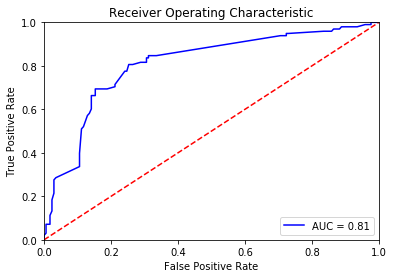

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Ex. 8** (20 points)

- Fit polynomial curves of order 0,1,2,3,4 and 5 to the values of $X$, $y$ given below 
- Using LOOCV, what is the degree of the best-fitting polynomial model? If this is not the true degree, explain why.

In [34]:
np.random.seed(23)

n = 10
k = 3
x = np.random.normal(0,1,n)
X = np.c_[np.ones(n), x, x**2, x**3]
beta = np.random.normal(0, 1, (k+1,1))
s = 0.5
y = X@beta
y += np.random.normal(0, s, y.shape)

Try with sklearn's PolynomialFeatures function

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn.linear_model as skl_lm

In [36]:
lm = skl_lm.LinearRegression()
crossvalidation = KFold(n_splits = len(x), random_state = 2017, shuffle = False) # Note: We are using 10 folds

In [37]:
for i in range(6):
    poly = PolynomialFeatures(degree = i)
    X_current = poly.fit_transform(x.reshape(-1,1))
    model = lm.fit(X_current, y)
    scores = cross_val_score(model, X_current, y, scoring = "neg_mean_squared_error", cv = crossvalidation,
                             n_jobs = 1)
    
    print("Degree-" + str(i) + " polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Degree-0 polynomial MSE: 1.4478212624445295, STD: 2.609298801984382
Degree-1 polynomial MSE: 1.029472876098173, STD: 1.3339976492763455
Degree-2 polynomial MSE: 0.27136302871853607, STD: 0.2774867730027457
Degree-3 polynomial MSE: 4.034114868925722, STD: 10.98609100510389
Degree-4 polynomial MSE: 35.74890917525461, STD: 105.604478401154
Degree-5 polynomial MSE: 39.73384521223993, STD: 117.35429724834694


It would appear that the best-fitting polynomial model has a degree of 2.